### **Libraries**

In [1]:
import gc
import warnings
import numpy as np
import pandas as pd

from fancyimpute import IterativeImputer as MICE

# Plots
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Take the PoliceKillingUS Dataset.**


In [2]:
df = pd.read_csv("PoliceKillingsUS.csv", encoding="cp1252")

In [3]:
pd.set_option("display.max_columns", df.shape[1])

In [4]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [5]:
df.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                        9
age                         77
gender                       0
race                       195
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        65
body_camera                  0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   int64  
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2458 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2340 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2470 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(1), 

In [7]:
df.describe()

,id,age
count,2535.000000,2458.000000
mean,1445.731755,36.605370
std,794.259490,13.030774
min,3.000000,6.000000
25%,768.500000,26.000000
50%,1453.000000,34.000000
75%,2126.500000,45.000000
max,2822.000000,91.000000


In [8]:
df.dropna(subset=["race"], inplace=True) # Deleting rows with missing values for race

In [9]:
df.drop(df.index[2363:], inplace=True) # Deleting deaths after 01/06/2017, as more info is missing about these, including vital information such as race

In [10]:
df.isnull().sum()

id                          0
name                        0
date                        0
manner_of_death             0
armed                       6
age                        29
gender                      0
race                        0
city                        0
state                       0
signs_of_mental_illness     0
threat_level                0
flee                       52
body_camera                 0
dtype: int64

### **Perform DataCleaning using SimpleImputer, LogisticRegression techniques**

In [11]:
num_cols=[]

for col in df.select_dtypes(['int64','float64']):
    num_cols.append(col)

In [12]:
obj_cols = []
for cols in df.select_dtypes("object"):
    obj_cols.append(cols)

In [13]:
tmp_df = pd.DataFrame(SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(df[obj_cols]))

In [14]:
cols = list(num_cols)
# Use MICE to fill in each row's missing features
num_df = pd.DataFrame(MICE(verbose=False).fit_transform(df[num_cols]))

In [15]:
num_df.isnull().sum()

0    0
1    0
dtype: int64

In [16]:
tmp_df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [17]:
df[num_cols] = num_df.values

In [18]:
df[obj_cols] = tmp_df.values

In [19]:
mod_df = df.drop(["id", "name"], axis=1)

In [20]:
min(mod_df.age)

6.0

In [21]:
max(mod_df.age)

91.0

In [22]:
mod_df['age_bins'] = pd.cut(mod_df.age,bins=[1, 18, 30, 45, 60, 100],labels=["Under 18", "18-29", "30-44", "45-59", "60 above"])

In [23]:
mod_df.head()

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,age_bins
0,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,45-59
1,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,45-59
2,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,18-29
3,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,30-44
4,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,30-44


### **Get the following insights:-**

#### **Top 10 cities which have most number of fatal shootings**

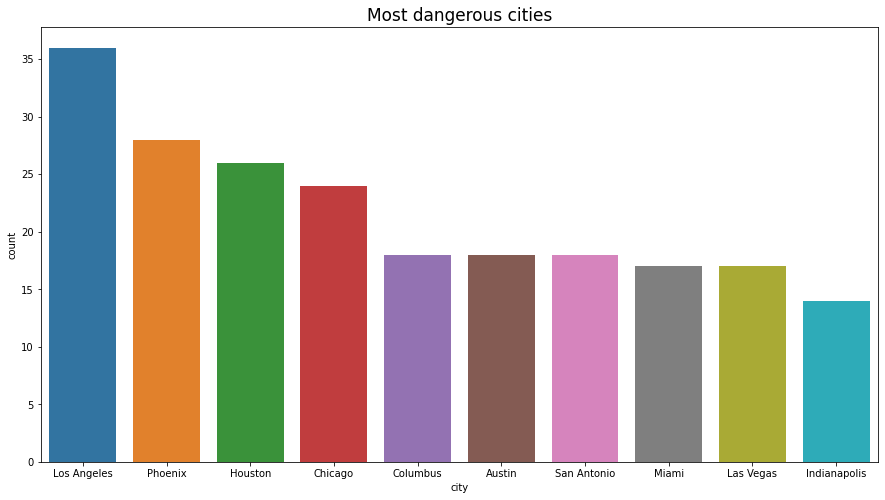

In [24]:
city = mod_df.city.value_counts(ascending=False)

df_city = mod_df.filter(["city"], axis=1)
df_city["count"] = 1

grouped_city = df_city.groupby("city", as_index=False,sort=False).sum()
grouped_city.sort_index(ascending=False)

grouped_city = grouped_city.sort_values("count", ascending=False).head(10)                                                       

fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(data=grouped_city, x="city", y="count", ax=ax)
ax.set_title("Most dangerous cities", fontsize=17)
plt.show()

#### **Age group of people killed along with reasons why were they killed and how were they killed**

age_bins  manner_of_death 
Under 18  shot                 96
          shot and Tasered      7
18-29     shot                741
          shot and Tasered     47
30-44     shot                840
          shot and Tasered     66
45-59     shot                406
          shot and Tasered     34
60 above  shot                 97
          shot and Tasered      6
dtype: int64


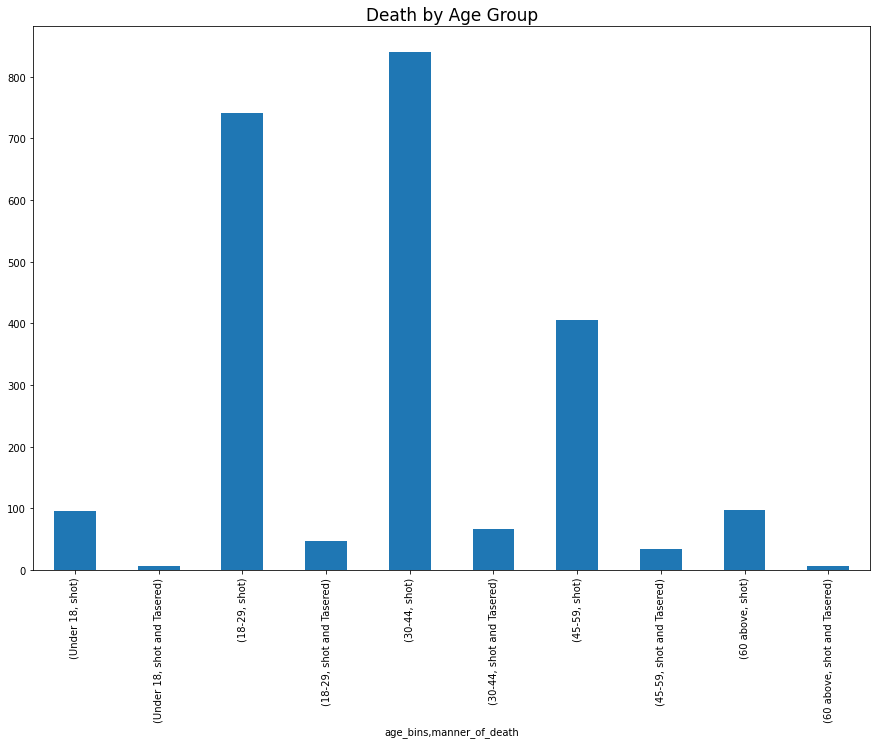

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
age_plot = mod_df.groupby(['age_bins', 'manner_of_death']).apply(lambda x: len(x))
print(age_plot)
age_plot.plot(kind='bar', figsize=(15, 10))
ax.set_title("Death by Age Group", fontsize=17)
plt.show()

#### **Visualize geographic locations using plotly.**


In [26]:
state_group = mod_df.groupby('state').size().reset_index(name='count')
state_df = pd.DataFrame(state_group)

In [27]:
choro_map = px.choropleth(
    state_df,
    color_continuous_scale = 'Viridis',
    range_color=(0, 12),
    locations="state", 
    color="count",
    scope="usa",
)
choro_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
choro_map.show()

### **Perform Label Encoding.**


In [28]:
mod_df.head()

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,age_bins
0,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,45-59
1,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,45-59
2,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,18-29
3,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,30-44
4,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,30-44


In [29]:
mod_df["signs_of_mental_illness"] = mod_df["signs_of_mental_illness"].astype(int)
mod_df["body_camera"] = mod_df["body_camera"].astype(int)

In [30]:
encoder = LabelEncoder()
encoder.fit(["armed", "race", "gender", "city", "state", "threat_level", "flee"])

LabelEncoder()

In [31]:
mod_df['manner_of_death']= mod_df['manner_of_death'].map({'shot':0, 'shot and Tasered':1})
mod_df['gender']= mod_df['gender'].map({'M':1, 'F':0})
mod_df['race']= mod_df['race'].map({'W':0, 'B':1, 'H':2, 'A':3, 'N': 4, 'O':5})
mod_df['threat_level']= mod_df['threat_level'].map({'attack':0, 'other':1, 'undetermined':2})

### **In KNN, plot the optimum K and use hamming distance for calculating the distance metric. If possible, try to implement hamming distance manually.**


In [32]:
final_df = mod_df.drop(["date", "age_bins", "armed", "state", "city", "flee"], axis=1)
X = final_df.drop("race", axis=1)
Y = final_df["race"]

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [34]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [35]:
pred = knn.predict(X_test)
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.60      0.54      0.57       359
           1       0.32      0.39      0.36       193
           2       0.17      0.14      0.15       123
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         7
           5       0.18      0.25      0.21         8

    accuracy                           0.41       702
   macro avg       0.21      0.22      0.21       702
weighted avg       0.42      0.41      0.42       702



In [36]:
knn_accuracy_score = accuracy_score(Y_test, pred)
knn_accuracy_score

0.4116809116809117

### **Fine-tune the parameters of KNN by using GridSearchCV - Hyperparameter Tuning**



In [37]:
error_rate = []

for i in range(1,30): # Checking every possible k value from 1-30

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))

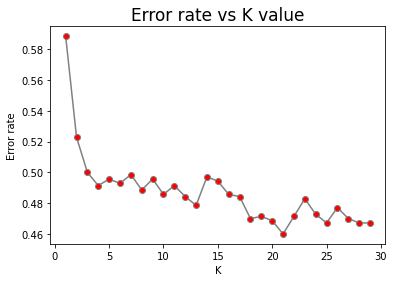

In [38]:
plt.plot(range(1,30), error_rate, color="grey", marker="o", markerfacecolor="red")
plt.title("Error rate vs K value", fontsize=17)
plt.xlabel("K")
plt.ylabel("Error rate")
plt.show()

k = 21 gives the lowest error rate

In [39]:
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, Y_train)
pred_1 = knn.predict(X_test)

print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.60      0.54      0.57       359
           1       0.32      0.39      0.36       193
           2       0.17      0.14      0.15       123
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         7
           5       0.18      0.25      0.21         8

    accuracy                           0.41       702
   macro avg       0.21      0.22      0.21       702
weighted avg       0.42      0.41      0.42       702



In [40]:
knn_accuracy_score_iter = accuracy_score(Y_test, pred_1)
knn_accuracy_score_iter

0.5398860398860399

In [41]:
param_grid = {
    "n_neighbors": np.arange(1, 50)
}

In [42]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X,Y)
print(knn_cv.best_score_)
print(knn_cv.best_params_)

0.5367521367521367
{'n_neighbors': 39}
